In [23]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns

In [2]:
train_dataset = keras.utils.image_dataset_from_directory(
    "..\\datasets\\dataset_half_cwt\\train",
    label_mode="categorical",
    batch_size=None,
    image_size=(64, 64),
    shuffle=False
)
val_dataset = keras.utils.image_dataset_from_directory(
    "..\\datasets\\dataset_half_cwt\\val",
    label_mode="categorical",
    batch_size=None,
    image_size=(64, 64),
    shuffle=False
)
test_dataset = keras.utils.image_dataset_from_directory(
    "..\\datasets\\dataset_half_cwt\\test",
    label_mode="categorical",
    batch_size=None,
    image_size=(64, 64),
    shuffle=False
)
train_dataset = train_dataset.map(lambda x, y: (tf.image.per_image_standardization(x), y))
train_dataset = train_dataset.shuffle(buffer_size=100, reshuffle_each_iteration=True).batch(64)
val_dataset = val_dataset.map(lambda x, y: (tf.image.per_image_standardization(x), y))
val_dataset = val_dataset.batch(val_dataset.cardinality())
test_dataset = test_dataset.map(lambda x, y: (tf.image.per_image_standardization(x), y))
test_dataset = test_dataset.batch(test_dataset.cardinality())

Found 400 files belonging to 5 classes.
Found 50 files belonging to 5 classes.
Found 50 files belonging to 5 classes.


In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(64, 64, 3)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 5)                 288005    
                                                                 
Total params: 307,397
Trainable params: 307,397
Non-trainable params: 0
__________________________________________________

In [15]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
history = model.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100
7/7 [==============================] - 4s 112ms/step - loss: 4.3049 - accuracy: 0.1325 - val_loss: 1.4055 - val_accuracy: 0.5200
Epoch 2/100
7/7 [==============================] - 0s 38ms/step - loss: 1.2941 - accuracy: 0.6650 - val_loss: 1.0187 - val_accuracy: 0.7600
Epoch 3/100
7/7 [==============================] - 0s 34ms/step - loss: 0.9382 - accuracy: 0.7175 - val_loss: 0.6226 - val_accuracy: 0.7600
Epoch 4/100
7/7 [==============================] - 0s 37ms/step - loss: 0.5817 - accuracy: 0.7800 - val_loss: 0.4543 - val_accuracy: 0.8800
Epoch 5/100
7/7 [==============================] - 0s 38ms/step - loss: 0.3765 - accuracy: 0.8825 - val_loss: 0.4862 - val_accuracy: 0.8400
Epoch 6/100
7/7 [==============================] - 0s 35ms/step - loss: 0.3218 - accuracy: 0.8825 - val_loss: 0.3856 - val_accuracy: 0.8800
Epoch 7/100
7/7 [==============================] - 0s 42ms/step - loss: 0.2363 - accuracy: 0.9100 - val_loss: 0.3334 - val_accuracy: 0.8600
Epoch 8/100
7/7 [==

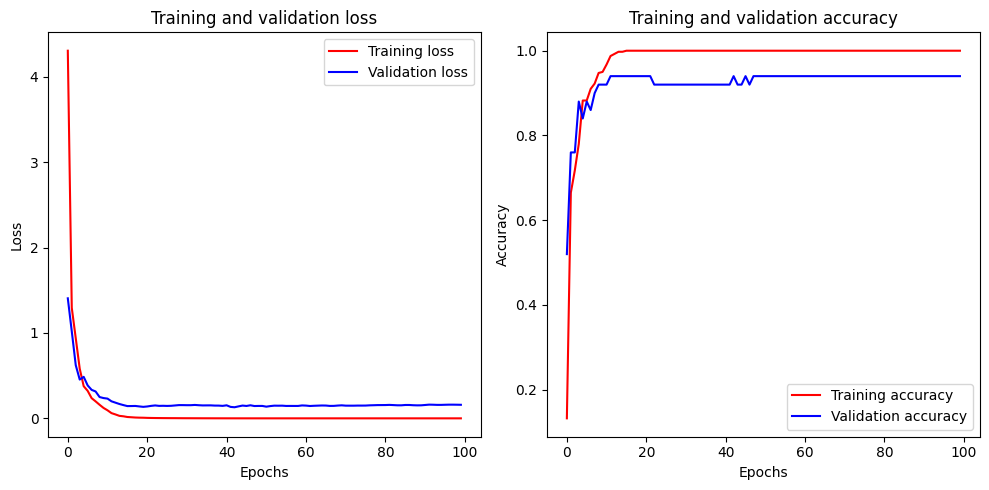

In [34]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epoch_list = range(100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_list, loss_values, 'r', label='Training loss')
ax1.plot(epoch_list, val_loss_values, 'b', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epoch_list, acc_values, 'r', label='Training accuracy')
ax2.plot(epoch_list, val_acc_values, 'b', label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig("loss_and_accuracy_curves.png")

In [20]:
model.save("model_100e.h5", save_format="h5")

In [21]:
loss, acc = model.evaluate(test_dataset)

1/1 [==============================] - 0s 114ms/step - loss: 0.0344 - accuracy: 0.9800


1/1 [==============================] - 0s 75ms/step


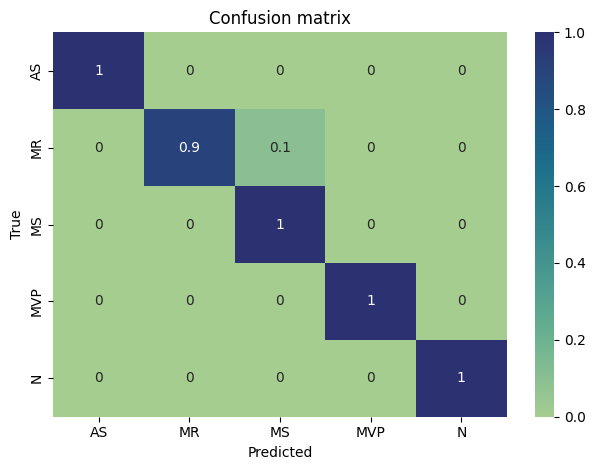

In [35]:
pred = model.predict(test_dataset)

true = next(test_dataset.as_numpy_iterator())[1]

labels = ["AS", "MR", "MS", "MVP", "N"]

y_true = np.argmax(true, axis=1)
y_pred = np.argmax(pred, axis=1)
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(conf_mat_normalized, annot=True, xticklabels=labels, yticklabels=labels, cmap="crest")
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.savefig("confusion_matrix.png")

In [24]:
precision_list, recall_list, fscore_list, _ = precision_recall_fscore_support(y_true, y_pred)
for i in range(5):
    print(f"Metrics for class '{labels[i]}':")
    print("Precision:", precision_list[i])
    print("Recall:", recall_list[i])
    print("F1-score:", fscore_list[i])
    print()
print("Average metrics:")
print("Precision:", np.average(precision_list))
print("Recall:", np.average(recall_list))
print("F1-score:", np.average(fscore_list))

Metrics for class 'AS':
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Metrics for class 'MR':
Precision: 1.0
Recall: 0.9
F1-score: 0.9473684210526315

Metrics for class 'MS':
Precision: 0.9090909090909091
Recall: 1.0
F1-score: 0.9523809523809523

Metrics for class 'MVP':
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Metrics for class 'N':
Precision: 1.0
Recall: 1.0
F1-score: 1.0

Average metrics:
Precision: 0.9818181818181818
Recall: 0.9800000000000001
F1-score: 0.9799498746867167
